In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Selección automática de características
A menudo recogemos una gran cantidad de características que pensamos que pueden estar relacionadas con una tarea predictiva, pero no sabemos cuáles son realmente útiles. Para mejorar la interpretabilidad de los modelos y, a veces, la capacidad de generalización, podemos aplicar métodos automáticos de selección de características que nos seleccionen un subconjunto de las características originales. Hay muchos tipos de algoritmos de selección de características, que iremos explicando en orden incremental de complejidad.

Para un modelo supervisado, la mejor estrategia de selección de características sería probar todos los subconjuntos de características, evaluando la capacidad de generalización en cada subconjunto. Sin embargo, el número de subconjuntos es exponencial con respecto al número de características, por lo que una búsqueda exhaustiva no es posible. Las estrategias que se describen en este libro de notas son aproximaciones a esta búsqueda exhaustiva.


### Estadísticos univariantes
El método más simple para seleccionar características es utilizar estadísticos univariantes, es decir, examinar cada característica individualmente y ejecutar un test estadístico para comprobar si esa característica esta relacionada con la variable objetivo. 

Vamos a crear un dataset sintético que contenga las características originales del dataset breast cancer, más 50 características totalmente aleatorias.

In [2]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# Semilla de números aleatorios
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# Añadir caracerísticas ruidosas a los datos
# las 30 primeras características son reales, las otras 50 son ruido
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target,
                                                    random_state=0, test_size=.5)

Tenemos que decidir un umbral para el $p$-value del test estadístico que nos permita decidir que características mantener. Hay varias estrategias implementadas en scikit-learn, una estrategia directa es ``SelectPercentile``, que mantienen un determinado percentil de las características (vamos a tomar un 50%):

In [3]:
from sklearn.feature_selection import SelectPercentile

# Utilizar el estadístico f_classif (por defecto)
# y SelectPercentile para mantener un 50% de las características:
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# Transformar los datos de entrenamiento
X_train_selected = select.transform(X_train)

print(X_train.shape)
print(X_train_selected.shape)

(284, 80)
(284, 40)


Podemos usar el estadístico para ver como de relevante es cada característica. Como breast cancer es un tarea de clasificación, vamos a usar f_classif, que es el test F para clasificación. A continuación, representamos los p-values asociados a cada una de las 80 características (las 30 originales más las 50 de ruido). Los p-values más bajos indican que las características son informativas:

In [4]:
from sklearn.feature_selection import f_classif, f_regression, chi2

In [5]:
F, p = f_classif(X_train, y_train)

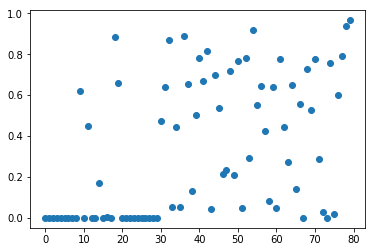

In [6]:
plt.figure()
plt.plot(p, 'o') #en la grafica se ve que estan ordenadas, las añadidas tienen pvalor alto, las primeras estan bien las segundas son ruido

Parece bastante claro que las primeras 30 características tienden a tomar p-values más bajos.

Volviendo al transformador SelectPercentile, podemos saber que características han sido seleccionados con el método ``get_support``:

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


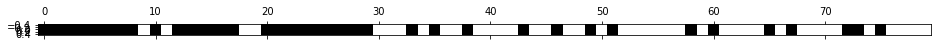

In [7]:
mask = select.get_support() #pone a true los 50 % que estan en el percentil, y a false el resto. Se nota que al pedirle 40 nos hemos pasado, habia 30 buenas 
print(mask)
# Visualizar la máscara. Los negros son True, los blancos son False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

Casi todas las 30 características originales se mantienen. También podemos analizar la utilidad de la selección de características entrenando un modelo a partir de los datos. Es importante que la selección de características siempre se entrene (método ``fit``) sobre el conjunto de entrenamiento (nunca sobre el de test):

In [8]:
from sklearn.linear_model import LogisticRegression

# Transformar los datos de test:
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Rendimiento en test con todas las características: %f" % lr.score(X_test, y_test))
lr.fit(X_train_selected, y_train)
print("Rendimiento en test solo con las características seleccionadas: %f" % lr.score(X_test_selected, y_test))

Rendimiento en test con todas las características: 0.929825
Rendimiento en test solo con las características seleccionadas: 0.940351


### Selección de características basada en un modelo
Un método más sofisticado es utilizar un modelo de aprendizaje automático y seleccionar las características en función de lo importantes que son para ese modelo. Esto requiere que el modelo proporcione algún mecanismo para ordenar las características en función de su importancia. Esto se puede hacer para todos los modelos basados en árboles (que implementan el método ``get_feature_importances``) y todos los modelos lineales, para los que podemos usar los coeficientes asociados a cada característica.

Cualquiera de estos modelos puede convertirse en un transformador que aplica selección de características mediante el uso de la clase envoltorio ``SelectFromModel``:

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")

In [10]:
select.fit(X_train, y_train)
X_train_rf = select.transform(X_train)
print(X_train.shape)
print(X_train_rf.shape) #agarra la mitad 40 por que le dijimos la mediana

(284, 80)
(284, 40)


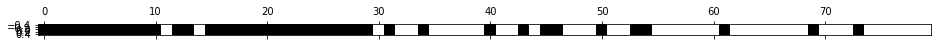

In [11]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [12]:
X_test_rf = select.transform(X_test)
LogisticRegression().fit(X_train_rf, y_train).score(X_test_rf, y_test)

0.9508771929824561

Este método construye un único modelo (en este caso un bosque aleatorio) y utiliza la importancia de las características. Podemos hacer una búsqueda algo más elaborada entrenando varios modelos en subconjuntos de los datos. Una estrategia particular es la eliminación recursiva de características:

### Eliminación recursiva de características
La eliminación recursiva de características construye un modelo a partir del conjunto completo de características y, al igual que antes, selecciona aquellas características que son más importantes para el modelo. Sin embargo, normalmente solo se descarta una característica del dataset y se construye un nuevo modelo con el resto de características. Este proceso de aplica de forma iterativa hasta que queden un determinado número de características:

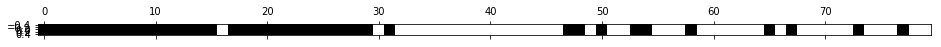

In [13]:
from sklearn.feature_selection import RFE
# RFE: Recursive Feature Eliminatio
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40) #queremos quedarnos con cuarenta

select.fit(X_train, y_train)
# Visualizar las características seleccionadas
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [14]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)

0.9508771929824561

In [15]:
# Este sería el score del RandomForest final obtenido por el RFE
select.score(X_test, y_test)

0.9508771929824561

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
      Crea el dataset XOR tal y como se indica en la celda siguiente.
      </li>
      <li>
      Añade características aleatorias al mismo y compara como la selección univariante actúa frente a la selección basada en modelos (bosques aleatorios), cuando el objetivo es conseguir recuperar las características originales.
      </li>
    </ul>
</div>

(200, 52)


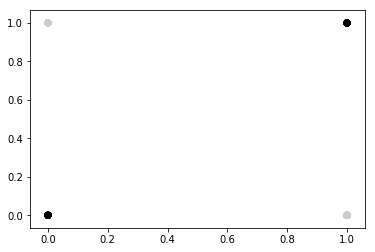

In [26]:
import numpy as np

rng = np.random.RandomState(1)

# Generar 400 valores enteros aleatorios en el rango [0, 1]
X = rng.randint(0, 2, (200, 2))
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)  # Creación del XOR

#Creo el vector de ruido
noise = rng.normal(size=(len(X), 50))
#Concateno el ruido a los datos
X_w_noise = np.hstack([X, noise])
print(X_w_noise.shape)

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, y, random_state=0, test_size=.15)



plt.scatter(X_w_noise[:, 0], X_w_noise[:, 1], c=plt.cm.spectral(y.astype(float)))